In [1]:
%matplotlib inline

import numpy as np

import matplotlib.image as mpimg

import matplotlib.pyplot as plt

import matplotlib.cm as cm

import png

import scipy.ndimage as ndimage

from scipy.misc import imsave, imshow

from scipy.ndimage import filters

import pyopencl as cl

import time

import fed

mf = cl.mem_flags

In [2]:
def show(img):
    plt.imshow(img, cm.Greys_r, interpolation='none', vmin = 0, vmax = 255)

In [3]:
def mse(A,B):
    return ((A - B) ** 2).mean()

In [4]:
# Precompute gaussian derivative kernel for convolution on GPU  
def gaussian_derivative(scale=1):
    #calculate sample points
    K = np.ceil(np.float32(3*scale))
    x = np.arange(-K, K+1) # -K, -K+1, ..., 0, ..., K-1, K
    
    #sample gaussian and normalize (zero-order 1D kernel)
    Gs = np.exp( -x**2 / (2*scale**2) )
    Gs = Gs / np.sum(Gs)
    
    gaussian_kernel = Gs
    #gaussian first derivative kernel
    gaussian_derivative_kernel = -x/(scale**2) * Gs
    
    return gaussian_kernel, gaussian_derivative_kernel

In [5]:
kernel_src = """
__constant float edge_threshold = 0.01;

inline int2 reflect(int2 i, const int h, const int w) {
  int2 ret = i;
  if (i.x < 0) {
    ret.x = abs(i.x);
  }
  if (i.x > w - 1) {
    ret.x = w - 1 - (i.x - (w - 1));
  }
  if (i.y < 0) {
    ret.y = abs(i.y);
  }
  if (i.y > h - 1) {
    ret.y = h - 1 - (i.y - (h - 1));
  }
  return ret;
}

inline float getpixel(const __global float * arr, const int2 pos, const int w) {
  return arr[pos.x + pos.y*w];
}

// dimensions of in should be powers of 2
// dimensions of out should each be half the corresponding dimensions of in
// kernel should be given out.shape
__kernel void scale_by_half(__global float * in,
                            __global float * out
                            )
{
    const int2 out_pos = {get_global_id(0), get_global_id(1)};
    const int width = get_global_size(0);
    const int in_width = width*2;
    
    // positions of the four input pixels we're going to average
    // ul = upper left, ur = upper right, etc
    const int2 ul_i = 2*out_pos;
    const int2 ur_i = ul_i + (int2)(1, 0);
    const int2 ll_i = ul_i + (int2)(0, 1);
    const int2 lr_i = ul_i + (int2)(1, 1);
    
    const float ul = getpixel(in, ul_i, in_width);
    const float ur = getpixel(in, ur_i, in_width);
    const float ll = getpixel(in, ll_i, in_width);
    const float lr = getpixel(in, lr_i, in_width);
    
    out[out_pos.x+out_pos.y*width] = 0.25 * (ul + ur + ll + lr);
}

// out should already contain the boundary pixels corresponding to the mask
__kernel void scale_up_dyadic(__global float * in,
                              __global float * out,
                              __global float * mask)

{
    // in is input image, should be half the size of out
    const int2 out_pos = {get_global_id(0), get_global_id(1)};
    const int width = get_global_size(0);
    
    const float is_pixel_in_mask = getpixel(mask, out_pos, width) == 0.0;
    
    if (is_pixel_in_mask) {
        return;
    }
    
    // now we're copying values of one pixel of in into corresponding four pixels of out
    // unless the values are in the mask
    // TODO: reduce runtime by reading even indices into cache, set barrier
    const int in_width = width/2;
    const int2 in_i = out_pos/2;

    out[out_pos.x+out_pos.y*width] = getpixel(in, in_i, in_width);
}

__kernel void convolve_1d(__global float * u_g,
                          __global float * mask_g,
                          const int maskSize,
                          const int axis,
                          __global float * out_g)
{
    const int2 pos = {get_global_id(0), get_global_id(1)};
    const int width = get_global_size(0);
    const int height = get_global_size(1);

    float sum = 0.0f;

    for (int a = -maskSize; a < maskSize+1; a++) {
        int2 shifted_pos;
        if (axis == 0) {
            shifted_pos = (int2)(pos.x  , pos.y+a);
        } else {
            shifted_pos = (int2)(pos.x+a, pos.y  );
        }
        const int2 rpos = reflect(shifted_pos, height, width);
        sum += mask_g[a+maskSize] * getpixel(u_g, rpos, width);
    }

    out_g[pos.x+pos.y*width] = sum;
}

__kernel void diffusivity_tensor(__global float * Rx_g,
                                 __global float * Ry_g,
                                 __global float * a_g,
                                 __global float * b_g,
                                 __global float * c_g)
{
    const int2 pos = {get_global_id(0), get_global_id(1)};
    const int width = get_global_size(0);
    
    const float Rx = getpixel(Rx_g, pos, width);
    const float Ry = getpixel(Ry_g, pos, width);
    
    const float Rx2 = Rx*Rx;
    const float Ry2 = Ry*Ry;
    const float Rw2 = Rx2+Ry2;
    const float Rw = sqrt(Rw2);
    
    // eigenvalues for diffusion tensor
    //const float c2 = 1.0/(1.0 + pown(Rw / edge_threshold, 2)); // Perona-Malik diffusivity across edges
    const float c2 = 1.0/sqrt((float)(1.0 + pown(Rw / edge_threshold, 2)));
    const float c1 = 1.0;                                      // full diffusion along edges
    
    // diffusion tensor components
    a_g[pos.x + pos.y*width] = (c1*Rx2 + c2*Ry2)   / (Rw2 + FLT_EPSILON);
    b_g[pos.x + pos.y*width] = (c2 - c1) * Rx * Ry / (Rw2 + FLT_EPSILON);
    c_g[pos.x + pos.y*width] = (c1*Ry2 + c2*Rx2)   / (Rw2 + FLT_EPSILON);
}

__kernel void eed_inpaint(__global float * u_g,
                          __global float * a_g,
                          __global float * b_g,
                          __global float * c_g,
                          __global float * mask_g,
                          __global float * tmp_g,
                          const float dt)
{
    const int2 pos = {get_global_id(0), get_global_id(1)};
    const int width = get_global_size(0);
    const int height = get_global_size(1);
    
    // see if we should skip this pixel if it's in the mask
    const bool shouldSkip = getpixel(mask_g, pos, width) == 0.0;
    if (shouldSkip) {
        tmp_g[pos.x + pos.y*width] = u_g[pos.x + pos.y*width];
        return;
    }
    
    // all needed indices with reflected boundary conditions
    const int2 mc_i = reflect(pos + (int2)(-1,  0), height, width); //pad_u[i0-1, i1]
    const int2 pc_i = reflect(pos + (int2)(+1,  0), height, width); //pad_u[i0+1, i1]
    const int2 cm_i = reflect(pos + (int2)( 0, -1), height, width); //pad_u[i0  , i1-1]
    const int2 cp_i = reflect(pos + (int2)( 0, +1), height, width); //pad_u[i0  , i1+1]
    const int2 mm_i = reflect(pos + (int2)(-1, -1), height, width); //pad_u[i0-1, i1-1]
    const int2 pm_i = reflect(pos + (int2)(+1, -1), height, width); //pad_u[i0+1, i1-1]
    const int2 mp_i = reflect(pos + (int2)(-1, +1), height, width); //pad_u[i0-1, i1+1]
    const int2 pp_i = reflect(pos + (int2)(+1, +1), height, width); //pad_u[i0+1, i1+1]
    const int2 cc_i = pos;
    
    // pixels and neighbors
    const float umc = getpixel(u_g, mc_i, width);
    const float upc = getpixel(u_g, pc_i, width);
    const float ucm = getpixel(u_g, cm_i, width);
    const float ucp = getpixel(u_g, cp_i, width);
    const float umm = getpixel(u_g, mm_i, width);
    const float upm = getpixel(u_g, pm_i, width);
    const float ump = getpixel(u_g, mp_i, width);
    const float upp = getpixel(u_g, pp_i, width);
    const float ucc = getpixel(u_g, cc_i, width);
    
    // diffusion tensor components
    const float amc = getpixel(a_g, mc_i, width);
    const float apc = getpixel(a_g, pc_i, width);
    const float acc = getpixel(a_g, cc_i, width);

    const float bmc = getpixel(b_g, mc_i, width);
    const float bpc = getpixel(b_g, pc_i, width);
    const float bcm = getpixel(b_g, cm_i, width);
    const float bcp = getpixel(b_g, cp_i, width);
    const float bcc = getpixel(b_g, cc_i, width);
    
    const float ccp = getpixel(c_g, cp_i, width);
    const float ccm = getpixel(c_g, cm_i, width);
    const float ccc = getpixel(c_g, cc_i, width);

    const float d = (
        -0.25 * (bmc+bcp) * ump +
         0.5  * (ccp+ccc) * ucp +
         0.25 * (bpc+bcp) * upp +
         0.5  * (amc+acc) * umc -
         0.5  * (amc+2*acc+apc+ccm+2*ccc+ccp) * ucc +
         0.5  * (apc+acc) * upc +
         0.25 * (bmc+bcm) * umm +
         0.5  * (ccm+ccc) * ucm -
         0.25 * (bpc+bcm) * upm
    );

    tmp_g[pos.x + pos.y*width] = u_g[pos.x + pos.y*width] + d * dt;
}


"""

In [6]:
class GpuManager(object):
    def __init__(self, prg_src):
        self.ctx = None
        self.queue = None
        self.prg = None
        
        self.prg_src = prg_src
        
        # kernels
        self.eed_inpaint_step = None
        self.convolve_1d = None
        self.diffusivity_tensor = None
        self.scale_down = None
        self.scale_up_with_mask = None
        
    def setup(self):
        # TODO: Make this more adaptive to different machines
        if self.ctx is not None:
            return
        
        # Acquire GPU resources
        platforms = cl.get_platforms()
        self.ctx = cl.Context(
            dev_type=cl.device_type.GPU,
            properties=[(cl.context_properties.PLATFORM, platforms[0])]
        )
        self.queue = cl.CommandQueue(self.ctx)
        
        # Compile GPU code
        self.prg = cl.Program(self.ctx, self.prg_src).build()
        
        # TODO: All code specific to prg_src (like kernel stuff) goes in subclass
        # Acquire handles to kernel functions
        self.eed_inpaint_step = self.prg.eed_inpaint
        self.eed_inpaint_step.set_scalar_arg_dtypes( [None, None, None, None, None, None, np.float32] )

        self.convolve_1d = self.prg.convolve_1d
        self.convolve_1d.set_scalar_arg_dtypes( [None, None, np.int32, np.int32, None] )

        self.diffusivity_tensor = self.prg.diffusivity_tensor
        self.scale_down = self.prg.scale_by_half
        self.scale_up_with_mask = self.prg.scale_up_dyadic

        
class Smoother(object):
    VERTICAL = 1
    HORIZONTAL = 0
    
    def __init__(self, gpu, sigma):
        self._gpu = gpu
        self._ctx = gpu.ctx
        self._queue = gpu.queue
        self._sigma = sigma
        
        self._gaussian_kernel_g = None
        self._gaussian_derivative_kernel_g = None
        self._half_mask_size = None
        
        self._image_shape = None
        
    def setup(self):
        gaussian_kernel, gaussian_derivative_kernel = gaussian_derivative(self._sigma)
        assert len(gaussian_kernel) % 2 == 1, "Gaussian kernel size must be odd"
        assert len(gaussian_derivative_kernel) % 2 == 1, "Gaussian kernel size must be odd"
        assert len(gaussian_kernel) == len(gaussian_derivative_kernel), "Gaussian kernels should be same size"
        
        self._half_mask_size = int(len(gaussian_kernel)//2)

        self._gaussian_kernel_g = cl.Buffer(self._ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=gaussian_kernel.astype(np.float32))
        self._gaussian_derivative_kernel_g = cl.Buffer(self._ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=gaussian_derivative_kernel.astype(np.float32))

    def set_image_shape(self, shape):
        self._image_shape = shape
        
    def _convolve(self, kernel_g, orientation, in_g, out_g):
        self._gpu.convolve_1d(self._queue, self._image_shape, None,
                              in_g, kernel_g, self._half_mask_size, orientation, out_g)
    
    def gaussian_smooth_h(self, in_g, out_g):
        self._convolve(self._gaussian_kernel_g, self.HORIZONTAL, in_g, out_g)
        
    def gaussian_smooth_v(self, in_g, out_g):
        self._convolve(self._gaussian_kernel_g, self.VERTICAL, in_g, out_g)
        
    def gaussian_derivative_smooth_h(self, in_g, out_g):
        self._convolve(self._gaussian_derivative_kernel_g, self.HORIZONTAL, in_g, out_g)
        
    def gaussian_derivative_smooth_v(self, in_g, out_g):
        self._convolve(self._gaussian_derivative_kernel_g, self.VERTICAL, in_g, out_g)


class FedInpainter(object):
    def __init__(self, gpu, smoother, shape, u_g, mask_g):
        self.gpu = gpu
        self.ctx = gpu.ctx
        self.queue = gpu.queue
        
        self.smoother = smoother
        
        self.shape = shape
        
        self.u_g = u_g
        self.mask_g = mask_g
        
        # gaussian partial derivative buffers
        self.Rx_g = None
        self.Ry_g = None
        self.Rw_g = None
        
        # diffusivity tensor buffers
        self.a_g = None
        self.b_g = None
        self.c_g = None
        
        # blitting buffer
        self.tmp_g = None
        
        self.time_simulated = 0.0
        self.num_iterations = 0
        self.result_g = None
        
    def setup(self):
        self.allocate_gpu_buffers()
        
    @property
    def _image_size_in_bytes(self):
        # height * width * (4 bytes per float32)
        return 4*(self.shape[0] * self.shape[1])
        
    def allocate_gpu_buffers(self):
        self.Rx_g = cl.Buffer(self.ctx, mf.READ_WRITE, size=self._image_size_in_bytes)
        self.Ry_g = cl.Buffer(self.ctx, mf.READ_WRITE, size=self._image_size_in_bytes)
        self.Rw_g = cl.Buffer(self.ctx, mf.READ_WRITE, size=self._image_size_in_bytes)

        # tmp buffer for things that need two steps
        self.tmp_g = cl.Buffer(self.ctx, mf.READ_WRITE, size=self._image_size_in_bytes)

        # Diffusivity tensor components
        # TODO: use float3 for abc to be all in one buffer
        self.a_g = cl.Buffer(self.ctx, mf.READ_WRITE, size=self._image_size_in_bytes)
        self.b_g = cl.Buffer(self.ctx, mf.READ_WRITE, size=self._image_size_in_bytes)
        self.c_g = cl.Buffer(self.ctx, mf.READ_WRITE, size=self._image_size_in_bytes)
        
    def inpaint(self, num_outer_cycles=3, total_diffusion_time=100.0):
        M = num_outer_cycles
        T = total_diffusion_time
        tau_max = 0.25
        N, tau = fed.fed_tau_by_process_time(T, M, tau_max, True)
        
        # Get the smoother ready
        self.smoother.set_image_shape(self.shape)
        
        in_g, out_g = self.u_g, self.tmp_g
        for m in xrange(M):
            # Rx
            self.smoother.gaussian_derivative_smooth_h(in_g, out_g)
            self.smoother.gaussian_smooth_v(out_g, self.Rx_g)
            # Ry
            self.smoother.gaussian_smooth_h(in_g, out_g)
            self.smoother.gaussian_derivative_smooth_v(out_g, self.Ry_g)
            # a, b, c
            self.gpu.diffusivity_tensor(self.queue, self.shape, None,
                                        self.Rx_g, self.Ry_g, # Inputs
                                        self.a_g, self.b_g, self.c_g # Outputs
                                       ) 
            for dt in tau:
                # EED step
                self.gpu.eed_inpaint_step(self.queue, self.shape, None,
                                          in_g, self.a_g, self.b_g, self.c_g, self.mask_g, out_g, dt)
                # swap tmp buffer with image buffer in prep for next step
                in_g, out_g = out_g, in_g
                self.time_simulated += dt
                self.num_iterations += 1
                
        # the most recently computed state will be in in_g after all the looping is done.
        # this might be self.u_g or self.tmp_g, depending on parity.
        self.result_g = in_g

    def get_result(self):
        result_np = np.empty(shape=self.shape, dtype=np.float32)
        cl.enqueue_copy(self.queue, result_np, self.result_g)
        return result_np


class CfedInpainter(object):
    def __init__(self, gpu, smoother, img, mask, num_outer_cycles=3, stopping_time=1600):
        self.gpu = gpu
        self.smoother = smoother
                
        self.img = img
        self.mask = mask
        
        self.num_outer_cycles = num_outer_cycles
        self.stopping_time = stopping_time

        self.img_scale1_g = None
        self.img_scale2_g = None
        self.img_scale4_g = None
        
        self.mask_scale1_g = None
        self.mask_scale2_g = None
        self.mask_scale4_g = None
        
        self.result_g = None
        self.num_iterations = 0
        
    def inpaint(self):
        h, w = self.img.shape
        is_power_of_two = lambda n: bin(n).count('1') == 1
        assert is_power_of_two(h), "Height must be a power of two."
        assert is_power_of_two(w), "Width must be a power of two."
        scale2_shape = (h//2, w//2)
        scale4_shape = (h//4, w//4)
        
        # Allocate GPU buffers for all three scales: 1/1, 1/2, and 1/4
        # After this, self.scale1 self.scale2 and self.scale4 are gpu buffers.
        # However, only self.scale1 is initialized.
        self.img_scale1_g, self.img_scale2_g, self.img_scale4_g = self._allocate_scaled_buffers(self.img)
        self.mask_scale1_g, self.mask_scale2_g, self.mask_scale4_g = self._allocate_scaled_buffers(self.mask)
        
        
        # Allocate all GPU buffers needed for diffusion
        inpainter1 = FedInpainter(self.gpu,
                                  self.smoother,
                                  self.img.shape,
                                  self.img_scale1_g,
                                  self.mask_scale1_g)
        inpainter1.setup()
        inpainter2 = FedInpainter(self.gpu,
                                  self.smoother,
                                  scale2_shape,
                                  self.img_scale2_g,
                                  self.mask_scale2_g)
        inpainter2.setup()
        inpainter4 = FedInpainter(self.gpu,
                                  self.smoother,
                                  scale4_shape,
                                  self.img_scale4_g,
                                  self.mask_scale4_g)
        inpainter4.setup()
        
        # Get the scaled down versions of image and mask, i.e., initialize self.scale2 and self.scale4
        self._scale_down(self.img_scale1_g, self.img_scale2_g, self.img_scale4_g)
        self._scale_down(self.mask_scale1_g, self.mask_scale2_g, self.mask_scale4_g)
        
        M = self.num_outer_cycles
        T = self.stopping_time
        # Do an inpainting pass on the lowest resolution image
        inpainter4.inpaint(M, T)
        
        # Scale up
        self._scale_up(scale2_shape, inpainter4.result_g, self.img_scale2_g, self.mask_scale2_g)
        
        # Do second inpainting pass
        inpainter2.inpaint(M, T)
        
        # Scale up to finest res
        self._scale_up(self.img.shape, inpainter2.result_g, self.img_scale1_g, self.mask_scale1_g)
        
        # Final inpainting pass
        inpainter1.inpaint(M, T)
        
        self.result_g = inpainter1.result_g
        self.num_iterations = inpainter1.num_iterations + inpainter2.num_iterations + inpainter4.num_iterations
        
    def _allocate_scaled_buffers(self, img):
        # TODO: assert dimensions are power of 2
        height, width = img.shape
        scale1 = cl.Buffer(self.gpu.ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))
        # Must specify size in bytes, so we have h*w*4 for 4 bytes for each float32
        scale2 = cl.Buffer(self.gpu.ctx, mf.READ_WRITE, size=4*(height/2*width/2))
        scale4 = cl.Buffer(self.gpu.ctx, mf.READ_WRITE, size=4*(height/4*width/4))
        return scale1, scale2, scale4
    
    def _scale_down(self, scale1_g, scale2_g, scale4_g):
        h, w = self.img.shape
        scale2_shape = (h//2, w//2)
        scale4_shape = (h//4, w//4)
        self.gpu.scale_down(self.gpu.queue, scale2_shape, None, scale1_g, scale2_g)
        self.gpu.scale_down(self.gpu.queue, scale4_shape, None, scale2_g, scale4_g)
    
    def _scale_up(self, shape, in_g, out_g, mask_g):
        self.gpu.scale_up_with_mask(self.gpu.queue, shape, None, in_g, out_g, mask_g)

    def get_result(self):
        result_np = np.empty(shape=self.img.shape, dtype=np.float32)
        cl.enqueue_copy(self.gpu.queue, result_np, self.result_g)
        return result_np
    
    def show(self, shape, buf_g):
        result_np = np.empty(shape=shape, dtype=np.float32)
        cl.enqueue_copy(self.gpu.queue, result_np, buf_g)
        show(result_np)
        

In [7]:
def do_cfed_inpainting(img, mask, sigma=4, M=3, T=1600):
    gpu = GpuManager(kernel_src)
    gpu.setup()
    smoother = Smoother(gpu, sigma=sigma)
    smoother.setup()
    
    inpainter = CfedInpainter(gpu, smoother, img, mask, num_outer_cycles=M, stopping_time=T)

    inpainter.inpaint()
    result_np = inpainter.get_result()
    return result_np


In [8]:
def do_fed_inpainting(img, mask, sigma=4, M=100, T=300000.0):
    gpu = GpuManager(kernel_src)
    gpu.setup()
    smoother = Smoother(gpu, sigma=4)
    smoother.setup()
    
    u_g = cl.Buffer(gpu.ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))
    mask_g = cl.Buffer(gpu.ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=mask.astype(np.float32))
    
    fed_inpainter = FedInpainter(gpu, smoother, img.shape, u_g, mask_g)
    fed_inpainter.setup()
    fed_inpainter.inpaint(M, T)
    result_np = fed_inpainter.get_result()
    return result_np
    
#do_fed_inpainting(img, inpainting_mask)
    
    
    

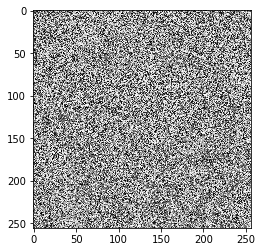

In [9]:
scarf_mask = ndimage.imread('./mask-scarf.png')
scarf_mask = 255-scarf_mask
scarf_orig = ndimage.imread('./orig-scarf.png')
scarf_img = np.copy(scarf_orig)
for i, x in np.ndenumerate(scarf_img):
    mask_val = scarf_mask[i]
    if mask_val > 0:
        scarf_img[i] = np.random.randint(0, 256)
show(scarf_img)

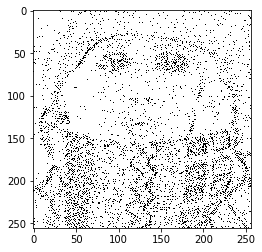

In [10]:
show(scarf_mask)

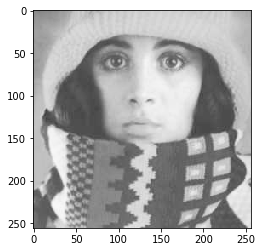

In [11]:
show(scarf_orig)

/Users/jake/venvs/cl-tutorial/lib/python2.7/site-packages/pyopencl/cffi_cl.py:1502: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


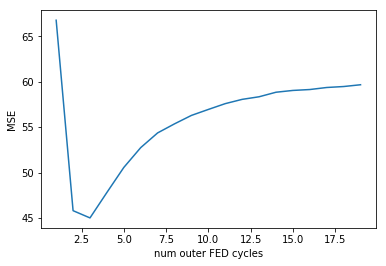

In [12]:
X = np.arange(1, 20)
Y = np.array([mse(do_cfed_inpainting(scarf_img, scarf_mask, T=1300, M=m), scarf_orig) for m in X])
plt.plot(X, Y)
plt.xlabel('num outer FED cycles')
plt.ylabel('MSE')
plt.show()

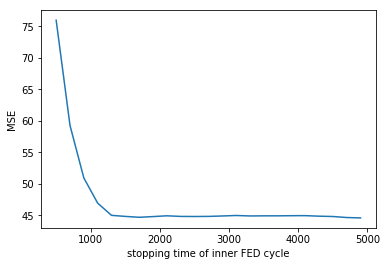

In [13]:
X = np.arange(500, 5000, 200)
Y = np.array([mse(do_cfed_inpainting(scarf_img, scarf_mask, T=t, M=3), scarf_orig) for t in X])
plt.plot(X, Y)
plt.xlabel('stopping time of inner FED cycle')
plt.ylabel('MSE')
plt.show()

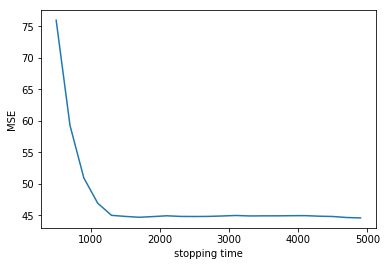

In [14]:
X = np.arange(500, 5000, 200)
Y = np.array([mse(do_cfed_inpainting(scarf_img, scarf_mask, T=t, M=3), scarf_orig) for t in X])
plt.plot(X, Y)
plt.xlabel('stopping time')
plt.ylabel('MSE')
plt.show()

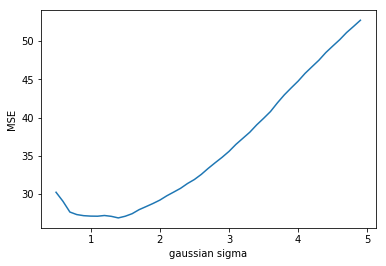

In [15]:
X = np.arange(0.5, 5, 0.1)
Y = np.array([mse(do_cfed_inpainting(scarf_img, scarf_mask, T=1600, M=3, sigma=x), scarf_orig) for x in X])
plt.plot(X, Y)
plt.xlabel('gaussian sigma')
plt.ylabel('MSE')
plt.show()

mse 26.5329


IOError: [Errno 2] No such file or directory: '/tmp/images/cfed1508087792.52.png'

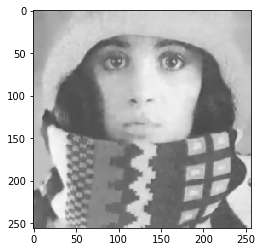

In [16]:
%%time
result = do_cfed_inpainting(scarf_img, scarf_mask, T=2000, M=3, sigma=0.8)
show(result)
print 'mse', mse(result, scarf_orig)
imsave('/tmp/images/cfed%s.png'%time.time(), result.astype(np.uint8))

In [111]:
def mask_ratio(my_mask):
    return (my_mask.shape[0]*my_mask.shape[1]) / float(np.unique(my_mask, return_counts=True)[1][0])

def make_mask(img):
    # schmaltz-pp329.pdf, page 17, pattern F
    # Keep only corners and center pixel
    h, w = img.shape
    mask = np.full_like(img, 255, dtype=np.uint8)
    mask[0,0]             = 0
    mask[0,w-1]       = 0
    mask[h-1,0]       = 0
    mask[h-1,w-1] = 0
    mask[h/2,w/2] = 0
    return mask

def make_inpainting_initial_img(img_orig, mask):
    inpainting_img = np.copy(img_orig)
    for i, x in np.ndenumerate(inpainting_img):
        mask_val = mask[i]
        if mask_val > 0:
            inpainting_img[i] = np.random.randint(0, 256)
    return inpainting_img

def is_power_of_2(n):
    log2n = np.log2(n)
    return log2n == np.floor(log2n)

def compress(img, mse_threshold=50, recursion_depth=0, recursion_depth_limit=5):
    assert len(img.shape) == 2, "Image must be greyscale"
    assert all(map(is_power_of_2, img.shape)), "Image dimensions must be power of 2"
    
    
    mask = make_mask(img)
    if recursion_depth >= recursion_depth_limit:
        return mask
    
    if img.shape[0] < 2**3 or img.shape[1] < 2**3:
        return mask
    
    inpainting_img = make_inpainting_initial_img(img, mask)
    result = do_cfed_inpainting(inpainting_img, mask, T=1500, M=3, sigma=0.8)
    result_mse = mse(result, img)
    
    if result_mse <= mse_threshold:
        return mask
    
    # Else, subdivide and recurse.
    h = img.shape[0]
    w = img.shape[1]
    
    if w >= h:
        axis = 1
    else:
        axis = 0
    
    partA, partB = np.split(img, 2, axis=axis)
    partA_mask = compress(partA,
                          mse_threshold=mse_threshold,
                          recursion_depth=recursion_depth+1,
                          recursion_depth_limit=recursion_depth_limit)
    partB_mask = compress(partB,
                          mse_threshold=mse_threshold,
                          recursion_depth=recursion_depth+1,
                          recursion_depth_limit=recursion_depth_limit)
    return np.concatenate((partA_mask, partB_mask), axis=axis)


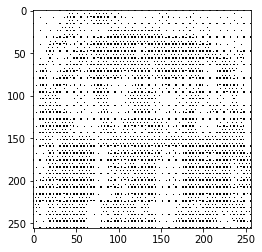

In [112]:
my_mask = compress(scarf_orig, recursion_depth_limit=60, mse_threshold=50)
show(my_mask)


46.1159
9.47736804049


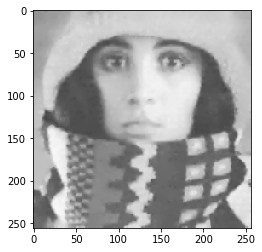

In [115]:
inpainting_img = make_inpainting_initial_img(scarf_orig, my_mask)
result = do_cfed_inpainting(inpainting_img, my_mask, T=1500, M=3, sigma=0.8)
result_mse = mse(result, scarf_orig)
print result_mse
show(result)
print mask_ratio(my_mask)

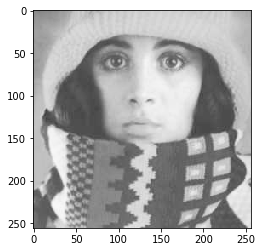

In [66]:
show(scarf_orig)

In [59]:
left, right = np.split(scarf_orig, 2, axis=1)

stacked = np.concatenate((left, right), axis=0)
stacked.shape

(512, 128)

In [107]:
mask_ratio(scarf_mask)

9.965936739659368